# FigS4b – ROI-based Fluorescence Intensity Analysis

## Overview
This notebook processes time-lapse fluorescence microscopy images and quantifies the average intensity within a user-defined Region of Interest (ROI).  
The ROI is defined by polygon annotations stored in JSON files. The script extracts raw intensities from two fluorescence channels and generates both numerical data and plots of intensity over time.

The analysis is designed for **full FRAP** experiments, where the entire ROI is bleached and no unbleached reference region is available.

---

## Input Requirements

1. **Two directories containing TIF images**
   - **Membrane channel** images  
   - **MreB channel** images  
   Filenames must include a timepoint identifier so that frames can be sorted and matched across channels.

2. **ROI annotation JSON files**
   - Generated from an image annotation tool (e.g. LabelMe)  
   - Each JSON contains polygon coordinates defining the ROI for a given frame  
   - The JSON filename should include the same timepoint identifier as the corresponding TIF image to allow matching

3. **Consistent frame indexing**
   - A `Frame` index is inferred from filenames and used to:
     - Match membrane and MreB images
     - Associate them with the correct ROI annotation
     - Define **pre-FRAP** and **post-FRAP** frames for normalization

---

## Processing Steps

For each matched membrane / MreB image pair and its ROI JSON:

1. **Load images and ROI**
   - Read the membrane-channel TIF
   - Read the MreB-channel TIF
   - Load the JSON file and rasterize the polygon into a binary mask

2. **Compute raw ROI intensities**
   - Apply the ROI mask to each channel
   - Compute the mean pixel value within the mask
   - Store as:
     - `Membrane_Raw_Intensity`
     - `mreb_Raw_Intensity`

3. **FRAP-style normalization (first frame = 1, second frame = 0)**  

   Since this is a full FRAP experiment with no separate reference region, we use a simple, frame-based normalization.

   Let the sorted unique frame indices be:

   $$
   f_1, f_2, f_3, \dots
   $$

   Interpret:

   - $f_1$: **pre-bleach** frame (before FRAP)
   - $f_2$: **first post-bleach** frame (after FRAP)

   For each channel, with raw intensity $I(t)$ at frame $t$, define:

   - $I_1 = I(f_1)$ (pre-bleach intensity)  
   - $I_2 = I(f_2)$ (first post-bleach intensity)

   The normalized FRAP curve is:

   $$
   F(t) = \frac{I(t) - I_2}{I_1 - I_2}
   $$

   This guarantees:

   - Pre-bleach frame:
     
     $$
     F(f_1) = 1
     $$

   - First post-bleach frame:
     
     $$
     F(f_2) = 0
     $$

   In the implementation:

   - The same transformation is applied independently to:
     - `Membrane_Raw_Intensity` → `Membrane_Normalized_Intensity`
     - `mreb_Raw_Intensity` → `mreb_Normalized_Intensity`
   - If $I_1 = I_2$ (degenerate case), the denominator is set to 1.0 to avoid division-by-zero.
   - Normalized values are clipped to the range $[0, 1]$ to suppress minor numerical overshoot due to noise.


---

## Outputs

The notebook produces:

1. **CSV file with per-frame intensity data**
   - Frame index and filenames  
   - `Membrane_Raw_Intensity`, `mreb_Raw_Intensity`  
   - `Membrane_Normalized_Intensity`, `mreb_Normalized_Intensity`  
     - Normalized according to  
       $$
       F(t) = \frac{I(t) - I_2}{I_1 - I_2}
       $$
       i.e.:
       - Pre-FRAP frame = 1.0  
       - First post-FRAP frame = 0.0  

2. **Plot(s) of normalized intensity vs. time**
   - FRAP recovery curves for both membrane and MreB channels  
   - Time axis in frames or in physical units (using `time_per_frame`)

3. **Summary statistics (optional)**
   - Basic statistics for raw and normalized intensities  
   - Final plateau values can be used as an approximate measure of recovery extent

---

## How to Run

1. **Set paths**
   - Update `membrane_dir`, `mreb_dir`, `output_svg_file`, and `output_csv_file` in the code cell to match your dataset.

2. **Configure analysis parameters**
   - Adjust `time_per_frame` and any other configuration variables as needed.

3. **Run all cells in order**
   - Execute the Jupyter Notebook from top to bottom.

4. **Inspect the outputs**
   - CSV file with raw and normalized intensity traces  
   - SVG (or other) plots showing normalized FRAP recovery curves for the selected ROI

=== File Mapping ===
t01: Half-frap-1-1125_t01c2.tif + Half-frap-1-1125_t01c1.tif -> Half-frap-1-1125_t01c2.json (from c1)
t06: Half-frap-1-1125_t06c2.tif + Half-frap-1-1125_t06c1.tif -> Half-frap-1-1125_t06c2.json (from c1)
t11: Half-frap-1-1125_t11c2.tif + Half-frap-1-1125_t11c1.tif -> Half-frap-1-1125_t11c2.json (from c1)
t16: Half-frap-1-1125_t16c2.tif + Half-frap-1-1125_t16c1.tif -> Half-frap-1-1125_t16c2.json (from c1)
t21: Half-frap-1-1125_t21c2.tif + Half-frap-1-1125_t21c1.tif -> Half-frap-1-1125_t21c2.json (from c1)
t26: Half-frap-1-1125_t26c2.tif + Half-frap-1-1125_t26c1.tif -> Half-frap-1-1125_t26c2.json (from c1)
t31: Half-frap-1-1125_t31c2.tif + Half-frap-1-1125_t31c1.tif -> Half-frap-1-1125_t31c2.json (from c1)
t36: Half-frap-1-1125_t36c2.tif + Half-frap-1-1125_t36c1.tif -> Half-frap-1-1125_t36c2.json (from c1)
t41: Half-frap-1-1125_t41c2.tif + Half-frap-1-1125_t41c1.tif -> Half-frap-1-1125_t41c2.json (from c1)
t46: Half-frap-1-1125_t46c2.tif + Half-frap-1-1125_t46c1.tif 

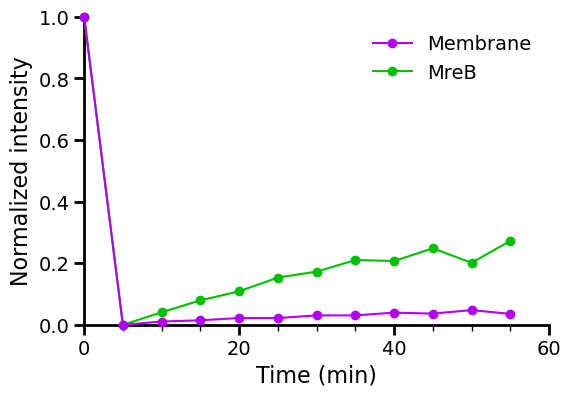

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from PIL import Image
import json
import os
import re
import glob
from pathlib import Path

# --- User-configurable parameters ---
# Replace with your actual file paths
membrane_dir = Path('00_FigS4b_raw/c2_membrane')
mreb_dir = Path('00_FigS4b_raw/c1_MreB')
output_svg_file = Path('02_FigS4b_plot_output/FigS4b.svg')
output_csv_file = Path('02_FigS4b_plot_output/FigS4b_intensity_data.csv')

# Time interval per frame (in minutes)
time_per_frame = 1

# --- Helper functions ---
def extract_timepoint(filename):
    """Extract timepoint number from filename for sorting"""
    match = re.search(r't(\d+)', filename)
    return int(match.group(1)) if match else 0

def read_tif_as_grayscale(tif_path):
    """Read TIF file in grayscale mode and return numpy array"""
    with Image.open(tif_path) as img:
        # Convert to grayscale mode
        gray_img = img.convert('L')
        return np.array(gray_img)

def find_json_file(timepoint, membrane_dir, mreb_dir):
    """Find JSON annotation file for given timepoint in either directory"""
    # Common patterns for JSON files
    patterns = [
        f'*t{timepoint:02d}*.json',
        f'*_t{timepoint:02d}_*.json',
        f'*-t{timepoint:02d}-*.json'
    ]
    
    # Search in both directories
    for directory in [membrane_dir, mreb_dir]:
        if os.path.exists(directory):
            for pattern in patterns:
                json_files = glob.glob(os.path.join(directory, pattern))
                if json_files:
                    return json_files[0]  # Return first match
    
    return None

def calculate_roi_intensity(image_array, json_path):
    """Calculate average intensity based on ROI coordinates from JSON file"""
    if not json_path or not os.path.exists(json_path):
        return None, None
    
    with open(json_path, 'r') as f:
        annotation = json.load(f)
    
    if not annotation.get('shapes'):
        return None, None
    
    # Get coordinates of the first shape
    points = annotation['shapes'][0]['points']
    
    # Create mask
    from PIL import Image, ImageDraw
    mask = Image.new('L', (image_array.shape[1], image_array.shape[0]), 0)
    ImageDraw.Draw(mask).polygon([tuple(point) for point in points], outline=1, fill=1)
    mask_array = np.array(mask)
    
    # Calculate average intensity within ROI
    roi_pixels = image_array[mask_array == 1]
    return np.mean(roi_pixels) if len(roi_pixels) > 0 else None, mask_array

def create_file_mapping(membrane_dir, mreb_dir):
    """Create mapping between Membrane and mreb files"""
    # Get TIF files from Membrane directory
    membrane_tif_files = [f for f in os.listdir(membrane_dir) if f.endswith('.tif')]
    membrane_tif_files.sort(key=extract_timepoint)
    
    # Get TIF files from mreb directory
    mreb_tif_files = [f for f in os.listdir(mreb_dir) if f.endswith('.tif')]
    mreb_tif_files.sort(key=extract_timepoint)
    
    # Create file mapping
    file_mapping = []
    
    print("=== File Mapping ===")
    for i, membrane_file in enumerate(membrane_tif_files):
        membrane_timepoint = extract_timepoint(membrane_file)
        
        # Find corresponding mreb file
        mreb_file = None
        for mreb_f in mreb_tif_files:
            if extract_timepoint(mreb_f) == membrane_timepoint:
                mreb_file = mreb_f
                break
        
        # Find JSON file in either directory
        json_file_path = find_json_file(membrane_timepoint, membrane_dir, mreb_dir)
        
        if mreb_file and json_file_path:
            mapping = {
                'timepoint': membrane_timepoint,
                'membrane_tif': membrane_file,
                'mreb_tif': mreb_file,
                'json_path': json_file_path
            }
            file_mapping.append(mapping)
            json_filename = os.path.basename(json_file_path)
            json_dir = 'c1' if membrane_dir in json_file_path else 'c2'
            print(f"t{membrane_timepoint:02d}: {membrane_file} + {mreb_file} -> {json_filename} (from {json_dir})")
        else:
            missing = []
            if not mreb_file:
                missing.append(f"mreb file for {membrane_file}")
            if not json_file_path:
                missing.append(f"JSON annotation for t{membrane_timepoint:02d}")
            print(f"Warning: Missing {', '.join(missing)}")
    
    print(f"\nTotal mappings created: {len(file_mapping)}\n")
    return file_mapping

def process_mapped_files(file_mapping, membrane_dir, mreb_dir):
    """Process mapped files and calculate ROI intensities for both channels"""
    data = []
    membrane_intensities = []
    mreb_intensities = []
    
    print("=== Processing Files and Calculating ROI Intensities ===")
    
    for mapping in file_mapping:
        timepoint = mapping['timepoint']
        membrane_tif_path = os.path.join(membrane_dir, mapping['membrane_tif'])
        mreb_tif_path = os.path.join(mreb_dir, mapping['mreb_tif'])
        json_path = mapping['json_path']
        
        # Read Membrane image
        membrane_image = read_tif_as_grayscale(membrane_tif_path)
        
        # Read mreb image
        mreb_image = read_tif_as_grayscale(mreb_tif_path)
        
        # Get ROI from JSON file and apply to both channels
        membrane_intensity, roi_mask = calculate_roi_intensity(membrane_image, json_path)
        
        if membrane_intensity is not None and roi_mask is not None:
            # Apply same ROI to mreb image
            mreb_roi_pixels = mreb_image[roi_mask == 1]
            mreb_intensity = np.mean(mreb_roi_pixels) if len(mreb_roi_pixels) > 0 else 0
            
            # Adjust time to start from 0 (first frame at x=0)
            time_adjusted = (timepoint - 1) * time_per_frame
            
            data.append({
                'Frame': timepoint,
                'Time/min': time_adjusted,
                'Membrane_Raw_Intensity': membrane_intensity,
                'mreb_Raw_Intensity': mreb_intensity
            })
            
            membrane_intensities.append(membrane_intensity)
            mreb_intensities.append(mreb_intensity)
            
            print(f"t{timepoint:02d}: Membrane_ROI={membrane_intensity:.2f}, mreb_ROI={mreb_intensity:.2f}")
        else:
            print(f"Warning: t{timepoint:02d} unable to obtain ROI information")
    
    df = pd.DataFrame(data)
    
    # FRAP-style normalization using first and second frames
    frames_sorted = sorted(df['Frame'].unique())
    if len(frames_sorted) >= 2:
        first_frame, second_frame = frames_sorted[0], frames_sorted[1]

        I1_mem = df.loc[df['Frame'] == first_frame, 'Membrane_Raw_Intensity'].iloc[0]
        I2_mem = df.loc[df['Frame'] == second_frame, 'Membrane_Raw_Intensity'].iloc[0]
        denom_mem = I1_mem - I2_mem
        if denom_mem == 0:
            denom_mem = 1.0  # Avoid division by zero when first two frames match
        df['Membrane_Normalized_Intensity'] = (df['Membrane_Raw_Intensity'] - I2_mem) / denom_mem

        I1_mreb = df.loc[df['Frame'] == first_frame, 'mreb_Raw_Intensity'].iloc[0]
        I2_mreb = df.loc[df['Frame'] == second_frame, 'mreb_Raw_Intensity'].iloc[0]
        denom_mreb = I1_mreb - I2_mreb
        if denom_mreb == 0:
            denom_mreb = 1.0  # Avoid division by zero when first two frames match
        df['mreb_Normalized_Intensity'] = (df['mreb_Raw_Intensity'] - I2_mreb) / denom_mreb
    else:
        df['Membrane_Normalized_Intensity'] = 0.0
        df['mreb_Normalized_Intensity'] = 0.0

    df['Membrane_Normalized_Intensity'] = df['Membrane_Normalized_Intensity'].clip(0, 1)
    df['mreb_Normalized_Intensity'] = df['mreb_Normalized_Intensity'].clip(0, 1)
    
    return df

# --- Main execution ---
try:
    # Create file mapping
    file_mapping = create_file_mapping(membrane_dir, mreb_dir)
    
    # Process mapped files
    df_combined = process_mapped_files(file_mapping, membrane_dir, mreb_dir)
    
    print(f"\n=== Processing Results ===")
    print(f"Successfully processed {len(df_combined)} timepoints")
    print("Data preview:")
    print(df_combined.head())
    
    # Save to CSV file
    df_combined.to_csv(output_csv_file, index=False)
    print(f"\nData successfully saved to CSV file: {output_csv_file}")

    # Create line plot
    plt.figure(figsize=(6, 4))

    purple_color = '#B200F4'
    green_color = '#00C000'

    ax = plt.gca()

    # Plot Membrane data (purple)
    ax.plot(
        df_combined['Time/min'],
        df_combined['Membrane_Normalized_Intensity'],
        marker='o',
        markersize=6,
        color=purple_color,
        label='Membrane',
        zorder=10,
        clip_on=False
    )

    # Plot mreb data (green)
    ax.plot(
        df_combined['Time/min'],
        df_combined['mreb_Normalized_Intensity'],
        marker='o',
        markersize=6,
        color=green_color,
        label='MreB',
        zorder=5,
        clip_on=False
    )

    # Set chart title and axis labels
    ax.set_xlabel('Time (min)', fontsize=16)
    ax.set_ylabel('Normalized intensity', fontsize=16)

    # Set X and Y axis tick font sizes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=14)
    ax.tick_params(axis='x', which='minor', length=4, width=1)
    ax.tick_params(axis='y', which='major', length=7, width=2, labelsize=14)


    # Set Y axis range and ticks
    ax.set_ylim(0, 1)
    ax.set_yticks(
        ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
    )

    # Set Y axis range and ticks
    ax.set_xlim(0,60)

    # Display legend
    ax.legend(
        loc='upper right',
        fontsize=14,
        frameon=False
    )

    # Remove top and right borders and adjust axis line width
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    # Save image as SVG file
    plt.savefig(output_svg_file, format='svg', bbox_inches='tight', dpi=300)
    print(f"Image successfully saved to: {output_svg_file}")
    
    # Display statistics
    print(f"\n=== Intensity Statistics ===")
    print(f"Membrane intensity statistics:")
    print(f"  Raw intensity range: {df_combined['Membrane_Raw_Intensity'].min():.2f} - {df_combined['Membrane_Raw_Intensity'].max():.2f}")
    print(f"  Normalized range: {df_combined['Membrane_Normalized_Intensity'].min():.2f} - {df_combined['Membrane_Normalized_Intensity'].max():.2f}")
    
    print(f"\nmreb intensity statistics:")
    print(f"  Raw intensity range: {df_combined['mreb_Raw_Intensity'].min():.2f} - {df_combined['mreb_Raw_Intensity'].max():.2f}")
    print(f"  Normalized range: {df_combined['mreb_Normalized_Intensity'].min():.2f} - {df_combined['mreb_Normalized_Intensity'].max():.2f}")
    

except Exception as e:
    print(f"Error occurred: {e}")
    import traceback
    traceback.print_exc()